<a href="https://colab.research.google.com/github/parmigggiana/ml-ids/blob/main/IDS_CICIDS2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web attack detection using CICIDS2017 dataset

This is an edited version of the original https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/web-attack-detection.ipynb

Training data: "Intrusion Detection Evaluation Dataset" (CICIDS2017). Description page: https://www.unb.ca/cic/datasets/ids-2017.html

The data set is public. Download link: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/

CICIDS2017 combines 8 files recorded on different days of observation (PCAP + CSV). Used archive: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/GeneratedLabelledFlows.zip

In the downloaded archive GeneratedLabelledFlows.zip the file "Thursday" Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv is selected.

Sources:

* [Sharafaldin2018] Iman Sharafaldin, Arash Habibi Lashkari and Ali A. Ghorbani. Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization. 2018
* [Kostas2018] Kahraman Kostas. Anomaly Detection in Networks Using Machine Learning. 2018 (error was found in assessing the importance of features)
* https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning (error was found in assessing the importance of features)

## Data preprocessing

Source: https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning/blob/master/01_preprocessing.ipynb [Kostas2018].

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

I will to use the corrected CIC-IDS-2017 instead of the original. 

In [2]:
!wget https://intrusion-detection.distrinet-research.be/CNS2022/Datasets/CICIDS2017_improved.zip -O dataset_new.zip
!unzip -u dataset_new.zip

--2023-06-14 17:36:00--  https://intrusion-detection.distrinet-research.be/CNS2022/Datasets/CICIDS2017_improved.zip
Resolving intrusion-detection.distrinet-research.be (intrusion-detection.distrinet-research.be)... 134.58.40.205
Connecting to intrusion-detection.distrinet-research.be (intrusion-detection.distrinet-research.be)|134.58.40.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343549013 (328M) [application/zip]
Saving to: ‘dataset_new.zip’

dataset_new.zip     100%[===================>] 327.63M  18.2MB/s    in 18s     

2023-06-14 17:36:20 (17.9 MB/s) - ‘dataset_new.zip’ saved [343549013/343549013]

Archive:  dataset_new.zip
  inflating: friday.csv              
  inflating: monday.csv              
  inflating: thursday.csv            
  inflating: tuesday.csv             
  inflating: wednesday.csv           


Using encoding='latin' avoids the UnicodeDecodeError we get otherwise

In [3]:
df = pd.read_csv('thursday.csv', encoding='latin')

As noted by the original work I'm readapting, only thursday's flows are used because they contained the least imbalanced data

In [4]:
df.shape

(362076, 91)

As for the differences between the features, aside for a couple of names that changed slightly, the corrected datasets adds 5 features: 'Fwd RST Flags', 'Bwd RST Flags', 'ICMP Code', 'ICMP Type', 'Total TCP Flow Time'. It also removed the duplicated feature 'Fwd Header Length.1'. 
Other than that, there's a column 'Attempted'. This should not be treated as a feature by the machine learning model. As suggested by the paper authors, we treat all those samples ad benign.

In [7]:
def clean_attempted(row):
  if row['Attempted Category'] != -1:
    row['Label'] = 'BENIGN'
  return row

df = df.apply(clean_attempted, axis=1) # apply function to each row

When assessing the distribution of labels, it turns out that out of 458968 records there are many blank records ("BENIGN" - benign background traffic).

In [8]:
df['Label'].unique()

array(['BENIGN', 'Web Attack - Brute Force', 'Infiltration',
       'Infiltration - Portscan', 'Web Attack - XSS',
       'Web Attack - SQL Injection'], dtype=object)

In [9]:
df['Label'].value_counts()

BENIGN                        290169
Infiltration - Portscan        71767
Web Attack - Brute Force          73
Infiltration                      36
Web Attack - XSS                  18
Web Attack - SQL Injection        13
Name: Label, dtype: int64

Delete blank records. This shouldn't make a difference since the new dataset already has no blank records.

In [10]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(362076, 91)

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [11]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

Replace the NaN values and infinity values with -1.

In [12]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.

In [13]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']

In [14]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

### Undersampling against unbalance

Dataset is unbalanced: total records = 170366, "BENIGN" records = 168186, records with attacks much less: 1507 + 652 + 21 = 2180.

In [15]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

290169

In [16]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

71907

In [17]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

BENIGN                        290169
Infiltration - Portscan        71767
Web Attack - Brute Force          73
Infiltration                      36
Web Attack - XSS                  18
Web Attack - SQL Injection        13
Name: Label, dtype: int64

We use **undersampling** to correct class imbalances: we remove most of the "BENIGN" records.

Form a balanced dataset web_attacks_balanced.csv in proportion: 30% attack (2180 records), 70% benign data (2180 / 30 * 70 ~ = 5087 records).

Algorithm to form a balanced df_balanced dataset:

* All the records with the attacks are copied to the new dataset.
* There are two conditions for copying "BENIGN" records to the new dataset:

     1. The next record is copyied with the benign_inc_probability.
     2. The total number of "BENIGN" records must not exceed the limit of 5087 records.

Сalculate the probability of copying a "BENIGN" record. The enlargement multiplier is used to get exactly 70% benign data (5087 records).

In [18]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

167783.0 0.6360476136320559


Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.

In [19]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [20]:
df_balanced['Label'].value_counts()

BENIGN                        167784
Infiltration - Portscan        71767
Web Attack - Brute Force          73
Infiltration                      36
Web Attack - XSS                  18
Web Attack - SQL Injection        13
Name: Label, dtype: int64

If necessary, we can keep a single class of attack for experiments.

In [21]:
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
# df_balanced['Label'].value_counts()

In [22]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

### Preparing data for training

In [23]:
df = pd.read_csv('web_attacks_balanced.csv')

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [24]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

If necessary, we will work with our own dataset.

In [25]:
#!wget https://raw.githubusercontent.com/infosecdemos/ml-2020/master/ml-ids/datasets/mix_labelled.zip -O mix_labelled.zip
#!unzip -u mix_labelled.zip

In [26]:
#df = pd.read_csv('mix_labelled.csv')
#excluded = ['Flow Key', 'Flow Bytes/s', 'Flow MB/s', 'Fwd IAT Min',
#            'Flow IAT Min', 'Packet Length Mean', 'Average Fwd Segment Size', 'Subflow Fwd Bytes',
#            'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Mean',
#            'Average Bwd Segment Size', 'Bwd Packet Length Mean', 'Packet Length List', 'Total Fwd Packets',
#            'Packet Length Std', 'Packet Length Variance', 'Total Backword Packets', 'Fwd Packet Length Std',
#            'Total Length of Bwd Packets', 'Bwd Header Length']
#df = df.drop(columns=excluded, errors='ignore')

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [27]:
excluded = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

Below at the stage of importance estimation the "Init_Win_bytes_backward" feature has the maximum value. After viewing the source dataset, it seems that an inaccuracy was made in forming the dataset.

It turns out that it is possible to make a fairly accurate classification by one feature.

Description of features: http://www.netflowmeter.ca/netflowmeter.html

     Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
     Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction




Notice how this is no longer true for the corrected dataset. The feature has been cleaned so we can avoid dropping it.

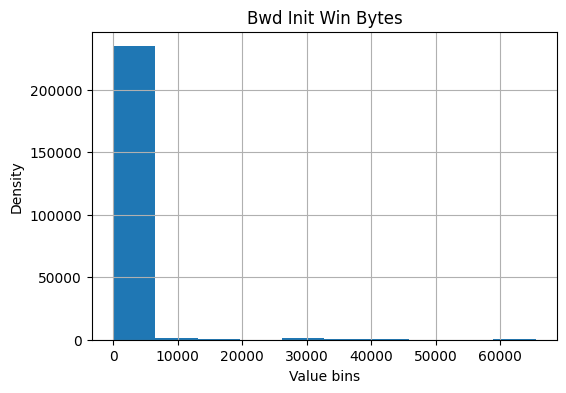

In [28]:
if 'Bwd Init Win Bytes' in df.columns:
    df['Bwd Init Win Bytes'].hist(figsize=(6,4), bins=10);
    plt.title("Bwd Init Win Bytes")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Bwd_Init_Win_Bytes.png', dpi=300)

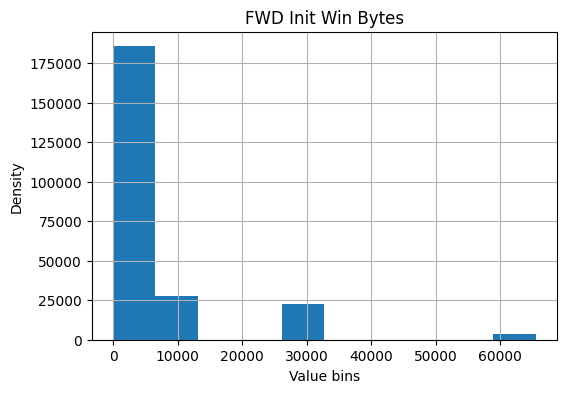

In [29]:
if 'FWD Init Win Bytes' in df.columns:
    df['FWD Init Win Bytes'].hist(figsize=(6,4), bins=10);
    plt.title("FWD Init Win Bytes")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('FWD_Init_Win_Bytes.png', dpi=300)

In [30]:
#excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
#df = df.drop(columns=excluded2, errors='ignore')

In [31]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(239691, 83) (239691,)


## Feature importance

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 117409, 1: 50374}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)

In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.

By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=2)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.99111985, 0.99189463, 0.99260981, 0.99296698, 0.99165574,
       0.99392061, 0.99392061, 0.99296698, 0.99249017, 0.99165574])

In [34]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Flow Duration <= 126.50
|   |--- FWD Init Win Bytes <= 786.00
|   |   |--- class: 0
|   |--- FWD Init Win Bytes >  786.00
|   |   |--- class: 1
|--- Flow Duration >  126.50
|   |--- SYN Flag Count <= 7.50
|   |   |--- Bwd RST Flags <= 1.50
|   |   |   |--- class: 0
|   |   |--- Bwd RST Flags >  1.50
|   |   |   |--- class: 0
|   |--- SYN Flag Count >  7.50
|   |   |--- class: 1



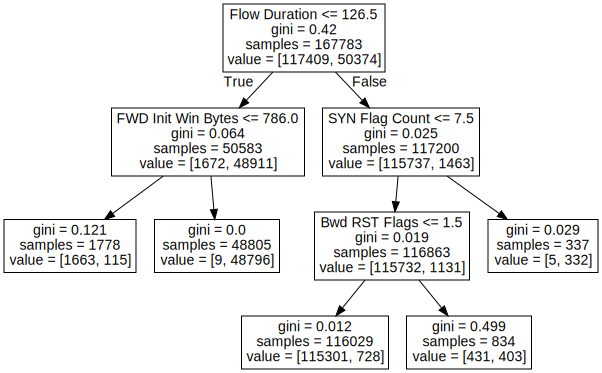

In [35]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

Analyze the confusion matrix. Which classes are confidently classified by the model?

In [36]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 50375, 1: 21533}

In [37]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[50366,     9],
       [  557, 20976]])

### Importance evaluation using SelectFromModel (still one decision tree)

Source: https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/select-from-model-nslkdd.ipynb

In [38]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.9412728 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00550801, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00935049, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0438687 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [39]:
sfm.threshold_

0.012048192771084338

In [40]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 83, selected num features: 2


In [41]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Flow Duration - 0.9412727997594796
1.	FWD Init Win Bytes - 0.0438686990052092
2.	SYN Flag Count - 0.009350487223918553
3.	Bwd RST Flags - 0.0055080140113926744
4.	Attempted Category - 0.0
5.	Bwd IAT Max - 0.0
6.	Fwd IAT Std - 0.0
7.	Fwd IAT Max - 0.0
8.	Fwd IAT Min - 0.0
9.	Bwd IAT Total - 0.0


### Evaluation of importance using RandomForestClassifier.feature_importances_ (move from one tree to a random forest, classification quality increases)

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 1.00 
R^2 Validation Score: 1.00 
Out-of-bag Score: 1.00


In [43]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:20]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#38	0.124	Fwd Packets/s
2.	#1	0.110	Flow Duration
3.	#18	0.105	Flow IAT Max
4.	#16	0.103	Flow IAT Mean
5.	#14	0.048	Flow Bytes/s
6.	#15	0.048	Flow Packets/s
7.	#42	0.046	Packet Length Mean
8.	#6	0.043	Fwd Packet Length Max
9.	#41	0.032	Packet Length Max
10.	#55	0.031	Fwd Segment Size Avg
11.	#54	0.028	Average Packet Size
12.	#64	0.024	Subflow Fwd Bytes
13.	#8	0.024	Fwd Packet Length Mean
14.	#10	0.023	Bwd Packet Length Max
15.	#5	0.022	Total Length of Bwd Packet
16.	#4	0.018	Total Length of Fwd Packet
17.	#12	0.017	Bwd Packet Length Mean
18.	#56	0.017	Bwd Segment Size Avg
19.	#70	0.012	Fwd Seg Size Min
20.	#67	0.011	FWD Init Win Bytes


For comparison, the results of the study [Sharafaldin2018] (compare relatively, without taking into account the multiplier):

* Init Win F.Bytes 0.0200
* Subflow F.Bytes 0.0145
* Init Win B.Bytes 0.0129
* Total Len F.Packets 0.0096

And incorrect results [Kostas2018] (error was found in assessing the importance of features, line: *impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})*, the importances[0:20] sample does not take into account that the values are not sorted in descending order):

* Flow Bytes/s 0.313402
* Total Length of Fwd Packets 0.304917
* Flow Duration 0.000485
* Fwd Packet Length Max 0.00013

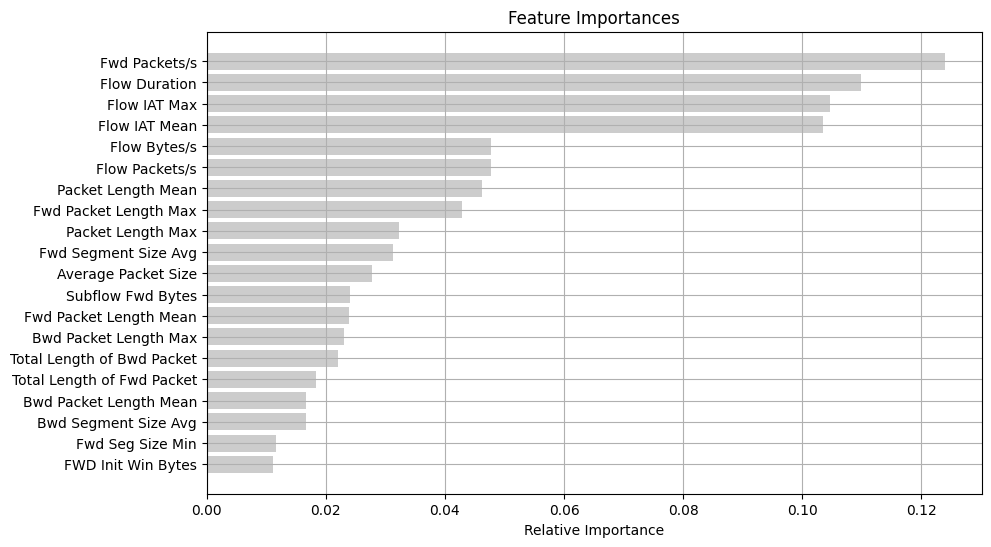

In [44]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[50368,     7],
       [    5, 21528]])

Next, for experiments, we keep the first max_features of features with maximum importance.

In [46]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Fwd Packets/s',
 'Flow Duration',
 'Flow IAT Max',
 'Flow IAT Mean',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Packet Length Mean',
 'Fwd Packet Length Max',
 'Packet Length Max',
 'Fwd Segment Size Avg',
 'Average Packet Size',
 'Subflow Fwd Bytes',
 'Fwd Packet Length Mean',
 'Bwd Packet Length Max',
 'Total Length of Bwd Packet',
 'Total Length of Fwd Packet',
 'Bwd Packet Length Mean',
 'Bwd Segment Size Avg',
 'Fwd Seg Size Min',
 'FWD Init Win Bytes']

## Analysis of selected features

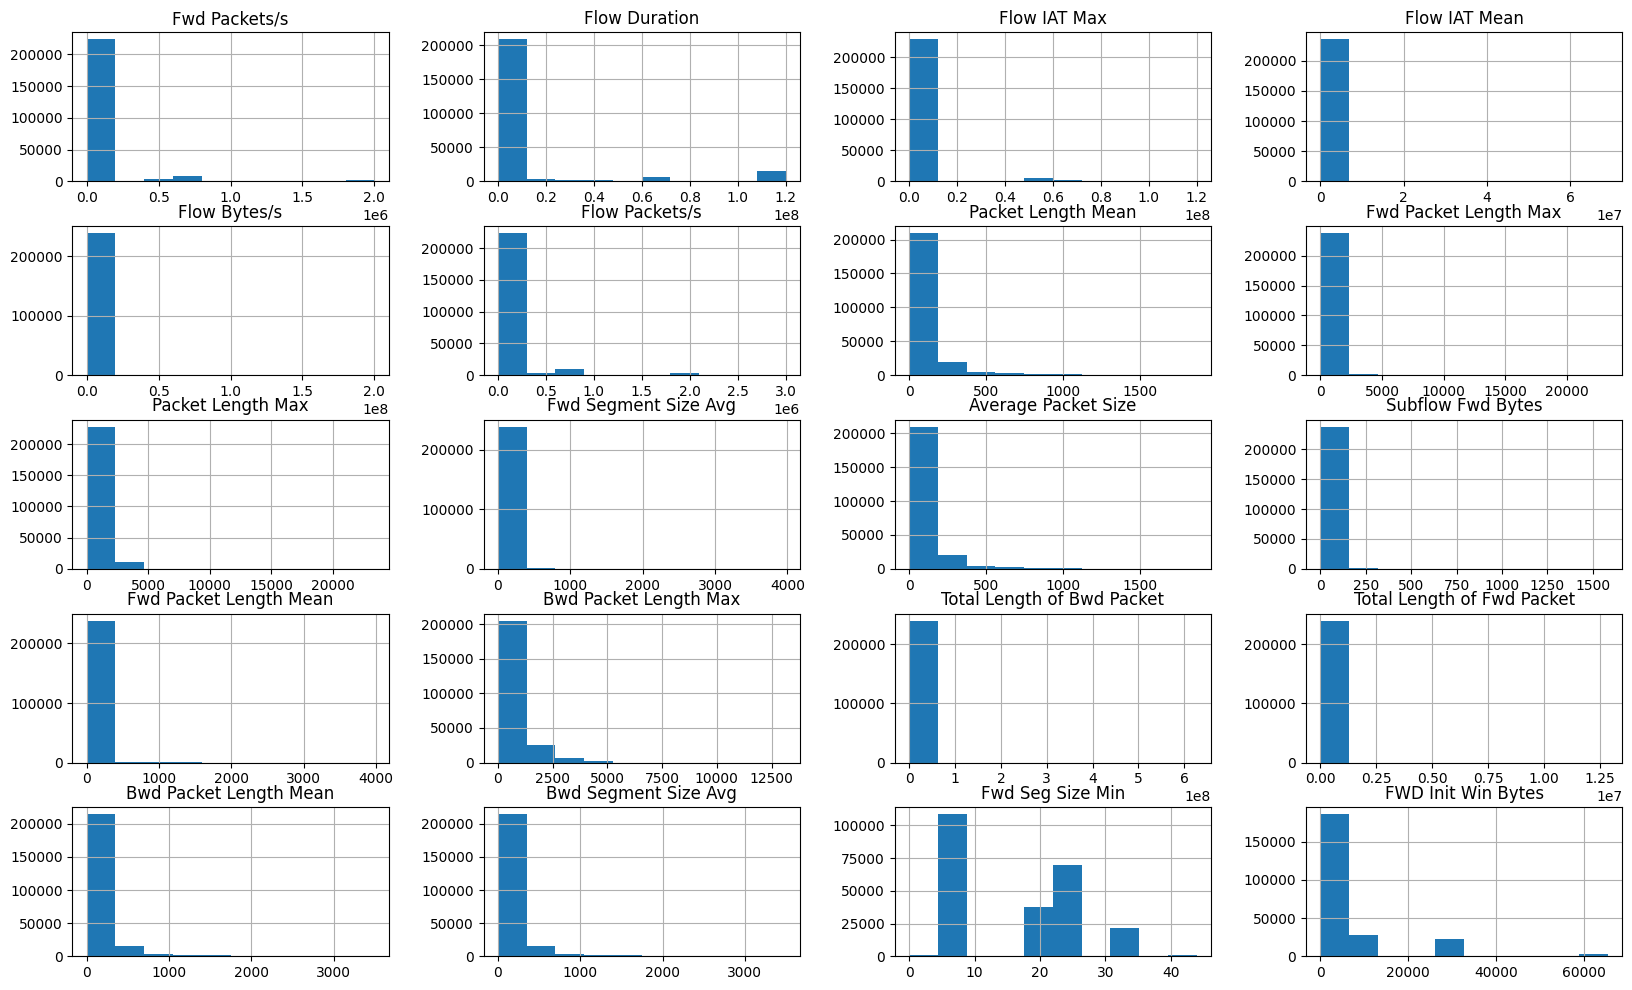

In [47]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

Install Facets Overview

https://pair-code.github.io/facets/

In [48]:
!pip install facets-overview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create the feature stats for the datasets and stringify it.

In [49]:
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train + test', 'table': df[webattack_features]}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

Display the facets overview visualization for this data.

In [50]:
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

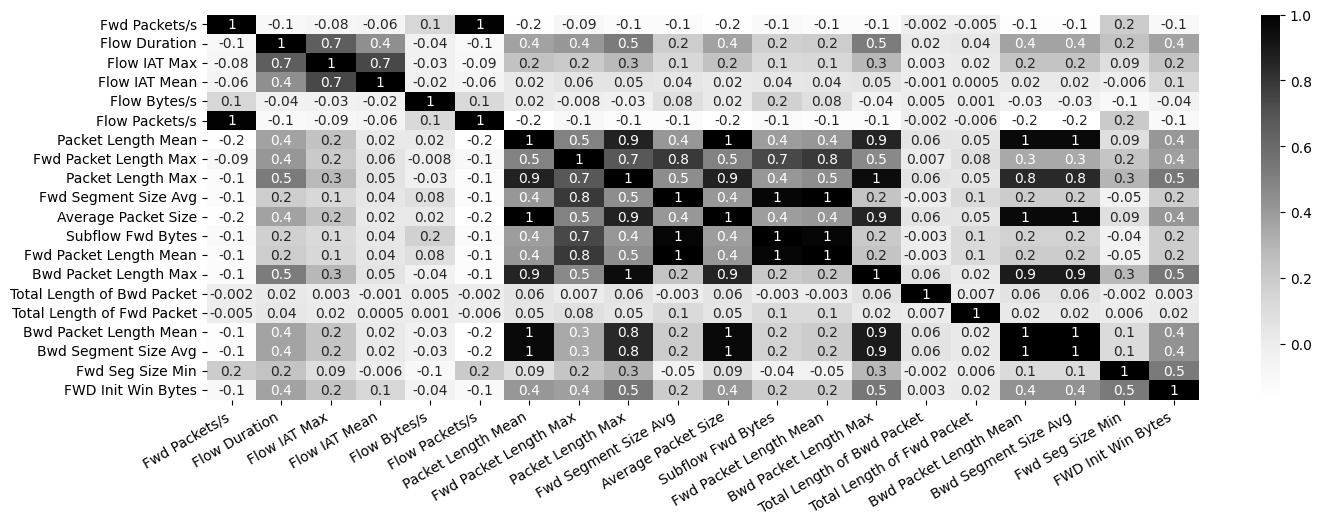

In [51]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

Remove correlated features.

In [52]:
to_be_removed = {'Flow Packets/s', 'Flow IAT Max', 'Packet Length Mean', 'Fwd Segment Size Avg', 'Fwd Packet Length Mean', 'Average Packet Size', 'Bwd Packet Length Max', 'Bwd Segment Size Avg', 'Packet Length Max'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Fwd Packets/s',
 'Flow Duration',
 'Flow IAT Mean',
 'Flow Bytes/s',
 'Fwd Packet Length Max',
 'Subflow Fwd Bytes',
 'Total Length of Bwd Packet',
 'Total Length of Fwd Packet',
 'Bwd Packet Length Mean',
 'Fwd Seg Size Min']

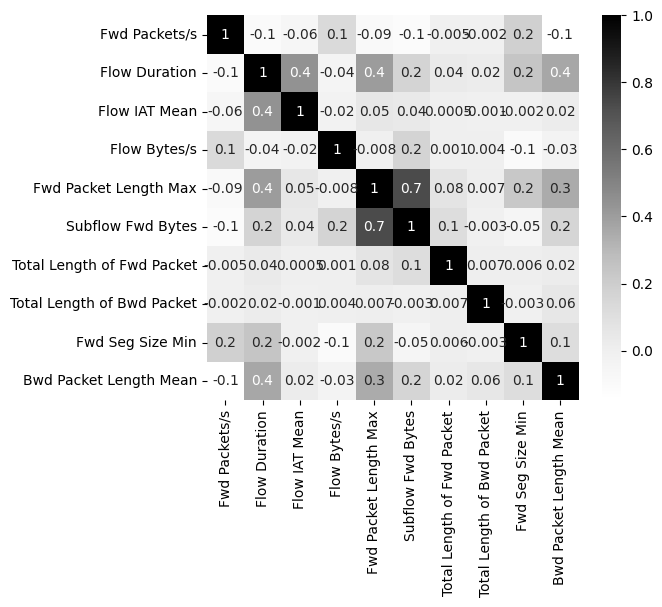

In [66]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys');

## Hyperparameter selection

Reopen the dataset.

In [54]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(239691, 10) (239691,)


If necessary, we will work with our own dataset.

In [55]:
#df = pd.read_csv('mix_labelled.csv')
#y = df['Label'].values
#X = df[webattack_features]
#print(X.shape, y.shape)

We get the list of RandomForestClassifier parameters.

In [56]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

For search of quasi-optimal value of one parameter we fix the others.

In [58]:
parameters = {'n_estimators': [25], # pretty much the same
              'min_samples_leaf': [2], # again no difference, 2 was best
              'max_features': [3], # Doesn't seem to make much difference, best was 4 but pretty much the same as 2
              'max_depth': [10]} # everything after 10 was pretty good, best is 20
scoring = {'f1', 'accuracy'}
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')
results = gcv.cv_results_

KeyboardInterrupt: ignored

AttributeError: ignored

In [ ]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head()

In [ ]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 5))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("n_estimators")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(2, 50)
ax.set_ylim(0.99, 1)

X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()

### Grid search

In [59]:
parameters = {'n_estimators': [10, 20, 50],
              'min_samples_leaf': [2, 3, 5],
              'max_features': [3, 5, 7, 10],
              'max_depth': [8, 12, 20]}

# parameters = {'n_estimators': [250]}

The operation may take a long time, 3-5 minutes depending on the computer performance.

In [60]:
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=3, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')

CPU times: user 1h 13min, sys: 4.84 s, total: 1h 13min 5s
Wall time: 1h 15min 2s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [8, 12, 20],
                         'max_features': [3, 5, 7, 10],
                         'min_samples_leaf': [2, 3, 5],
                         'n_estimators': [10, 20, 50]},
             refit='f1', return_train_score=True, scoring={'f1', 'accuracy'})

Let's take a look at the results of the parameter selection.

In [61]:
gcv.best_estimator_

RandomForestClassifier(max_depth=20, max_features=3, min_samples_leaf=2,
                       n_estimators=20, random_state=1)

In [62]:
gcv.best_params_

{'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 20}

In [63]:
gcv.best_score_

0.9989488998150976

## Final model

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(167783, 10) (167783,)
(71908, 10) (71908,)


In [80]:
rfc = RandomForestClassifier(max_depth=20, max_features=3, min_samples_leaf=2, n_estimators=25, random_state=42, oob_score=True)
# rfc = RandomForestClassifier(n_estimators=250, random_state=1)
rfc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestClassifier(max_depth=20, max_features=3, min_samples_leaf=2,
                       n_estimators=25, oob_score=True, random_state=42)

In [81]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#1	0.414	Flow Duration
2.	#2	0.214	Flow IAT Mean
3.	#0	0.200	Fwd Packets/s
4.	#3	0.042	Flow Bytes/s
5.	#4	0.042	Fwd Packet Length Max
6.	#7	0.041	Total Length of Fwd Packet
7.	#9	0.036	Fwd Seg Size Min
8.	#8	0.005	Bwd Packet Length Mean
9.	#5	0.003	Subflow Fwd Bytes
10.	#6	0.003	Total Length of Bwd Packet


In [82]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[167765,     19],
       [    19,  71888]])

In [83]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9998414625496994
Precision = 0.9997357698137872
Recall = 0.9997357698137872
F1 = 0.9997357698137872


## Model saving

In [84]:
import pickle
with open('webattack_detection_rf_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

## Model approbation

Open the previously saved model.

In [85]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(max_depth=20, max_features=3, min_samples_leaf=2,
                       n_estimators=25, oob_score=True, random_state=42)

Reopen the dataset.

In [86]:
df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = df['Label'].values
X_test = df[webattack_features]
print(X_test.shape, y_test.shape)

(239691, 10) (239691,)


If necessary, we will work with our own dataset.

In [87]:
#df = pd.read_csv('mix_labelled.csv')
#y_test = df['Label'].values
#X_test = df[webattack_features]
#print(X_test.shape, y_test.shape)

In [88]:
X_test.head()

,Fwd Packets/s,Flow Duration,Flow IAT Mean,Flow Bytes/s,Fwd Packet Length Max,Subflow Fwd Bytes,Total Length of Bwd Packet,Total Length of Fwd Packet,Bwd Packet Length Mean,Fwd Seg Size Min
0,1.250568,119945515,8.050035e+05,0.000000,0,0,0,0,0.000000,0
1,0.424420,113095465,1.592894e+06,174.012282,403,134,10012,9668,417.166667,32
2,0.599258,113473706,1.060502e+06,212.225377,403,105,12718,11364,317.950000,32
3,0.618310,116446503,9.868348e+05,246.241830,1313,112,15294,13380,325.404255,32
4,3.246936,63752405,3.094777e+05,263.629270,153,81,0,16807,0.000000,8


In [89]:
import time
seconds = time.time()
y_pred = rfc.predict(X_test)
print("Total operation time:", time.time() - seconds, "seconds")

print("Benign records detected (0), attacks detected (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Total operation time: 0.5159633159637451 seconds
Benign records detected (0), attacks detected (1):


{0: 167784, 1: 71907}

Confusion matrix:

      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

In [90]:
confusion_matrix(y_test, y_pred)

array([[167765,     19],
       [    19,  71888]])

In [91]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9998414625496994
Precision = 0.9997357698137872
Recall = 0.9997357698137872
F1 = 0.9997357698137872


Manual calculation of the confusion matrix:

    array([[5075,   12],
           [   1, 2179]], dtype=int64)

      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

    Точность
    Precision = TP / (TP + FP) = 2179 / (2179 + 12) = 0.9945230488361478

    Полнота
    Recall = TP / (TP + FN) = 2179 / (2179 + 1) = 0.9995412844036697

    F-мера, параметр = 1, гармоническое среднее точности и полноты, множитель = 2
    F1 = 2 * (precision * recall) / (precision + recall) = 0.9970258522077328

    Доля правильных ответов
    Accuracy = TP + TN / (TP + TN + FP + FN) = (2179 + 5075) / 7267 = 0.998211091234347

In [92]:
predict = pd.DataFrame({'Predict': rfc.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
result = X_test.join(label).join(predict)

In [93]:
result[result['Predict'] == 1]

,Fwd Packets/s,Flow Duration,Flow IAT Mean,Flow Bytes/s,Fwd Packet Length Max,Subflow Fwd Bytes,Total Length of Bwd Packet,Total Length of Fwd Packet,Bwd Packet Length Mean,Fwd Seg Size Min,Label,Predict
15152,5.786723,35253111,114458.152597,3292.957606,602,142,72181,43906,687.438095,32,1,1
25115,30303.030303,33,33.000000,0.000000,0,0,0,0,0.000000,32,0,1
25116,18518.518519,54,54.000000,0.000000,0,0,0,0,0.000000,32,0,1
25117,34482.758621,29,29.000000,0.000000,0,0,0,0,0.000000,32,0,1
35943,46.028132,119991834,10861.938445,23887.992245,1274,259,287,2866077,0.051946,20,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
239686,500000.000000,4,4.000000,0.000000,0,0,0,0,0.000000,24,1,1
239687,41666.666667,48,48.000000,0.000000,0,0,0,0,0.000000,24,1,1
239688,41666.666667,48,48.000000,0.000000,0,0,0,0,0.000000,24,1,1
239689,666666.666667,3,3.000000,0.000000,0,0,0,0,0.000000,24,1,1


In [94]:
result[410:430]

,Fwd Packets/s,Flow Duration,Flow IAT Mean,Flow Bytes/s,Fwd Packet Length Max,Subflow Fwd Bytes,Total Length of Bwd Packet,Total Length of Fwd Packet,Bwd Packet Length Mean,Fwd Seg Size Min,Label,Predict
410,38.846266,51485,1.716167e+04,4.311936e+03,37,18,148,74,74.000000,8,0,0
411,11111.111111,180,6.000000e+01,1.400000e+06,31,15,190,62,95.000000,8,0,0
412,0.029391,68047862,2.268262e+07,2.821543e+00,48,24,96,96,48.000000,8,0,0
413,0.050869,117949764,1.310553e+07,5.256475e+00,208,30,320,300,80.000000,20,0,0
414,0.050834,118030682,1.311452e+07,1.139534e+01,479,57,774,571,193.500000,20,0,0
415,0.076357,117867634,6.548202e+06,5.015796e+01,782,88,4239,1673,423.900000,20,0,0
416,0.062500,64000119,9.142874e+06,5.999989e+00,48,24,192,192,48.000000,8,0,0
417,0.030292,66023094,2.200770e+07,2.908073e+00,48,24,96,96,48.000000,8,0,0
418,0.051213,117156732,1.464459e+07,7.579590e+00,416,56,380,508,126.666667,20,0,0
419,53.816968,37163,1.238767e+04,1.431531e+04,28,14,476,56,238.000000,8,0,0
